In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
from __future__ import print_function
import cplex
import matplotlib.pyplot as plt

In [2]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    '''
    input: initial number of unit/share each assest, initial leftover cash, return estimates, covariance estimates, price at that day
    output: optimal number of unit/share each assest, leftover cash after rebalance
    '''
    # total number of stocks
    n = 20
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # asset weight is 1/n, each asset value is 1/n * total value
    x_optimal = np.floor(np.ones((20))/20 * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal


In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    # total number of stocks
    n = 20
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # we dont have linear part of objective function for variance
    c  = [0.0] * n
    # bounds on variables weight 1-20, each weight should between (0,1)
    ub = [1.0] * n
    lb = [0.0] * n
    # Define constraints cols and add right-hand-side of constraints
    cols = [[[0, 1], [1, 0]],[[0, 1], [1, 0]]]*10
    # want sum(x1,x20)=1
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
    # Add linear part of objective function, bounds on variables, and linear constraints to CPLEX model
    cpx.variables.add(obj=c, ub=ub, lb=lb, columns=cols,
                  names=["w1","w2","w3","w4","w5","w6","w7","w8","w9","w10",
                         "w11","w12","w13","w14","w15","w16","w17","w18","w19","w20"])
    # Add quadratic part of objective variance function to CPLEX model
    # covariance matrix is 20x20, we want to sum(ρijσiσjwiwj) for each ij
    qmat = []
    for i in range(n):
        qmat.append([list(range(n)),list(2*Q[i,:])])
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # disable output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # optimization
    cpx.solve()
    
    # asset weight
    w_opt = np.array(cpx.solution.get_values())
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # each asset value is wi * total value
    x_optimal = np.floor(w_opt * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    # Annual risk-free rate for years 2020-2021 is 2.5%
    rf_ann = 0.025
    # number of trading days in 2020 is from row 43 to 295
    rf = 0.025/(295-43)
    # optimize 20 y, 1 k
    n = 21
    # Initialize CPLEX object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    # we dont have linear part of objective function for variance
    c  = [0.0] * n
    # bounds on variables y1-y20, k, should be larger than 0
    ub = [np.inf] * n
    lb = [0.0] * n
    # define additional return
    add_ret = mu-rf * np.ones(20)
    # Define constraints cols and add right-hand-side of constraints
    # sum(add_ret * yi) = 1
    # sum(yi) - k = 0
    cols = []
    for k in range(n-1):
        cols.append([[0, 1],[add_ret[k], 1]])
    cols.append([[0, 1],[0, -1]])
    cpx.linear_constraints.add(rhs=[1.0, 0.0], senses="EE")
    # Add linear part of objective function, bounds on variables, and linear constraints to CPLEX model
    var_names = ["y_%s" % i for i in range(1,n)]
    var_names.append('k')
    cpx.variables.add(obj=c, ub=ub, lb=lb, columns=cols, names=var_names)
    
    # modify Q to add risk free, Q_new is 21 x 21
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q_new = np.vstack([Q1,np.zeros((21))])
    # Add quadratic part of objective variance function to CPLEX model
    # covariance matrix is 21x21, we want to sum(ρijσiσjyiyj) for each ij
    qmat = []
    for i in range(n):
        qmat.append([list(range(n)),list(2*Q_new[i,:])])
    cpx.objective.set_quadratic(qmat)
    # Set CPLEX parameters
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    # disable output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    # optimization
    cpx.solve()
    
    # optimized y and k
    y = np.array(cpx.solution.get_values())
    # optimized weight w=y/k
    w_opt = y[:20]/y[20]
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # each asset value is wi * total value
    x_optimal = np.floor(w_opt * port_value / cur_prices)
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal
    

In [6]:
a = ["y_%s" % i for i in range(1,20+1)]
a.append('k')
a


['y_1',
 'y_2',
 'y_3',
 'y_4',
 'y_5',
 'y_6',
 'y_7',
 'y_8',
 'y_9',
 'y_10',
 'y_11',
 'y_12',
 'y_13',
 'y_14',
 'y_15',
 'y_16',
 'y_17',
 'y_18',
 'y_19',
 'y_20',
 'k']

In [7]:
qmat = []
for i in range(3):
    qmat.append([list(range(3)),list(range(3))])
qmat

[[[0, 1, 2], [0, 1, 2]], [[0, 1, 2], [0, 1, 2]], [[0, 1, 2], [0, 1, 2]]]

## 2. Analyze results

In [8]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# print(Q)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']

### CHANGE TO TEST ###
# N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
   else:
        cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
     

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
            # propotion of each stock unit of share to total unit of share
            propotion = x[strategy, period-1] / sum(x[strategy, period-1])
            # value deduction of each stock
            v_deduction = abs(cash[strategy, period-1]) * propotion
            # unit of share deduction of each stock
            x_deduction = np.ceil(v_deduction/cur_prices)
            # deduct the share from optimal bunch
            x[strategy, period-1] = x[strategy, period-1] - x_deduction
            # new cost - transaction cost is 0.5% of the traded volume
            new_cost = 0.005 * np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions))
            # total portfolio value
            port_value = np.dot(cur_prices,curr_positions) + curr_cash
            # modify cash - cash flow is the difference btw
            # portfolio value before re-balancing and 
            # value of portfolio after re-balancing plus the transaction fees
            cash[strategy, period-1] = port_value - (np.dot(cur_prices,x[strategy, period-1]) + new_cost)
        

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
 

### Plot one chart in Python that illustrates the daily value of your portfolio

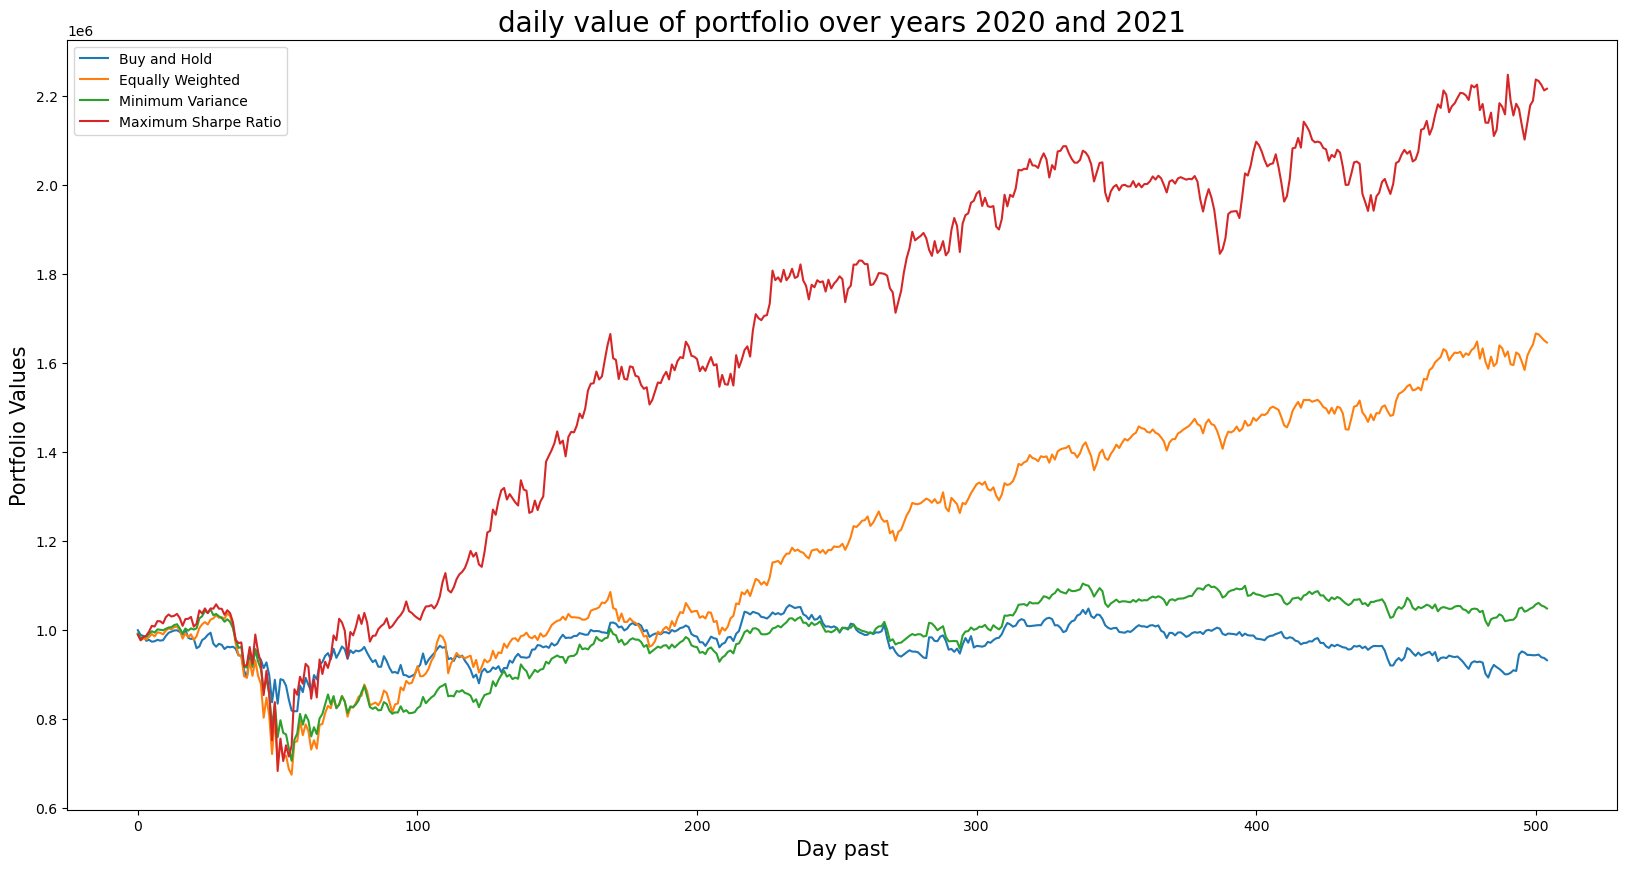

In [9]:
###################### Insert your code here ############################
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.title('daily value of portfolio over years 2020 and 2021',fontsize=20)
plt.xlabel('Day past',fontsize=15)
plt.ylabel('Portfolio Values',fontsize=15)
plt.legend()
plt.show()

### Plot two charts in Python for strategy 3 and 4 to show dynamic changes in portfolio allocations.

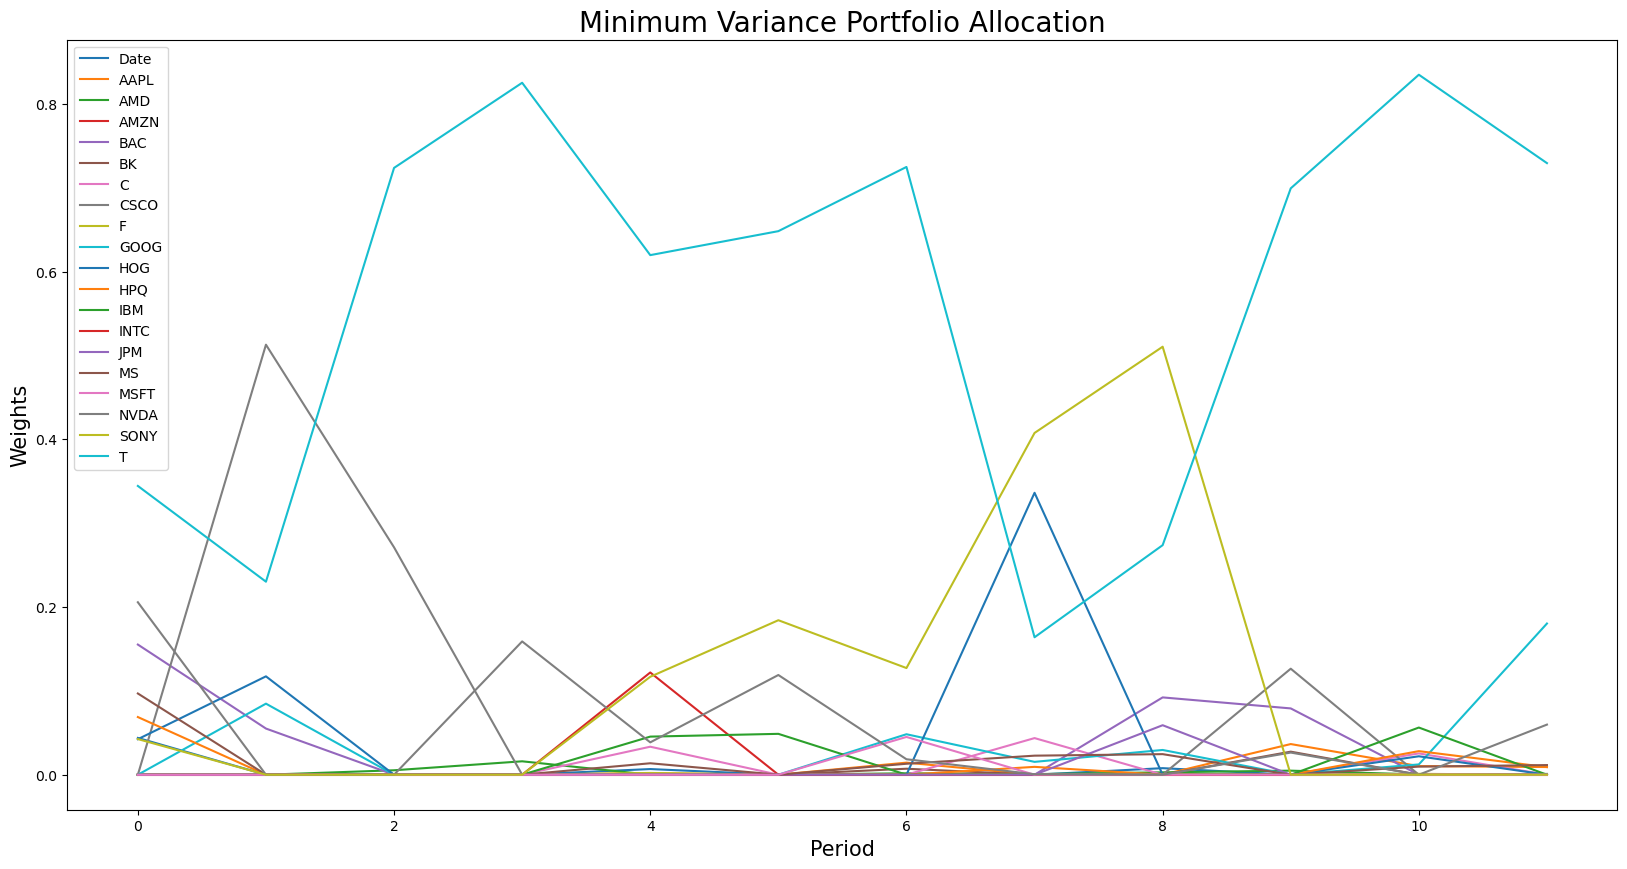

In [10]:
plt.figure(figsize=(20,10))

for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 3 at index 2
        w_all = x[2, period-1]/sum(x[2, period-1])
        w_period.append(w_all[stock])
    plt.plot(w_period,label=df.columns[stock])

plt.title('Minimum Variance Portfolio Allocation',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

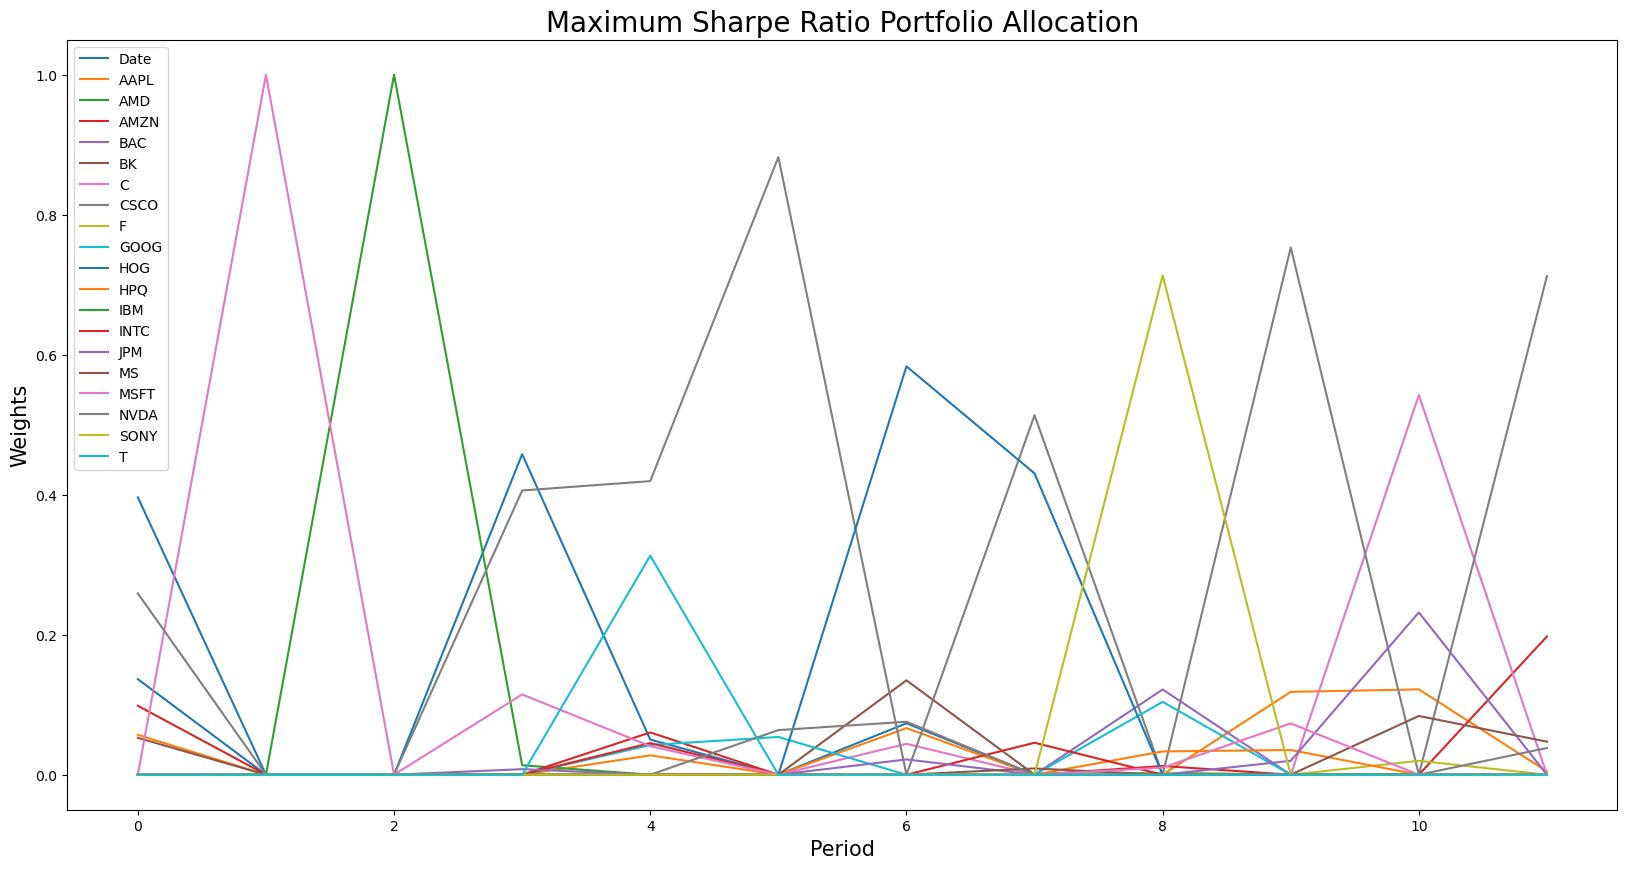

In [11]:
plt.figure(figsize=(20,10))

for stock in range(20):
    # we want to store weight of each stock 1-20 for 12 periods
    w_period = []
    for period in range(1, N_periods+1):
        # strategy 4 at index 3
        w_all = x[3, period-1]/sum(x[3, period-1])
        w_period.append(w_all[stock])
    plt.plot(w_period,label=df.columns[stock])

plt.title('Maximum Sharpe Ratio Portfolio Allocation',fontsize=20)
plt.xlabel('Period',fontsize=15)
plt.ylabel('Weights',fontsize=15)
plt.legend()
plt.show()

## 2. Discuss possible improvements to your trading strategies

In [12]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# We want to get the share of each stock we want to hold for this new strategy
x_equal_hold, cash_equal_hold = strat_equally_weighted(init_positions, 0, mu, Q, data_prices[0])

print('Asset hold in each stock for Equal Weight and Hold Strategy:\n', x_equal_hold)

Asset hold in each stock for Equal Weight and Hold Strategy:
 [ 675. 1018.   26. 1468. 1041.  659. 1097. 5425.   36. 1389. 2560.  426.
  864.  378. 1013.  317.  835.  724. 1507.  904.]


In [13]:
def strat_equal_hold(x_init, cash_init, mu, Q, cur_prices):
    '''
    select “1/n” portfolio at the beginning of period 1 and hold it till the end of period 12
    '''
    # total number of stocks
    n = 20
    # initial portfolio value
    port_value = np.dot(cur_prices,x_init) + cash_init
    # asset weight is 1/n in period 1, number of asset is defined in previous step
    x_optimal = x_equal_hold
    # transaction cost is 0.5% of the traded volume
    tran_cost = 0.005 * np.dot(cur_prices , abs(x_optimal-x_init))
    # cash flow is the difference btw
    # portfolio value before re-balancing and 
    # value of portfolio after re-balancing plus the transaction fees
    cash_optimal = port_value - (np.dot(cur_prices,x_optimal) + tran_cost)

    return x_optimal, cash_optimal

### Produce output for 5 strategies

In [14]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)
# print(Q)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe','strat_equal_hold']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio','Equal Weight and Hold Portfolio']

### CHANGE TO TEST ###
# N_strat = 4  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_hold]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
        cur_year  = 20 + math.floor(period/7)
   else:
        cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs
     

      ###################### Insert your code here ############################
      if cash[strategy, period-1] < 0:
            # propotion of each stock unit of share to total unit of share
            propotion = x[strategy, period-1] / sum(x[strategy, period-1])
            # value deduction of each stock
            v_deduction = abs(cash[strategy, period-1]) * propotion
            # unit of share deduction of each stock
            x_deduction = np.ceil(v_deduction/cur_prices)
            # deduct the share from optimal bunch
            x[strategy, period-1] = x[strategy, period-1] - x_deduction
            # new cost - transaction cost is 0.5% of the traded volume
            new_cost = 0.005 * np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions))
            # total portfolio value
            port_value = np.dot(cur_prices,curr_positions) + curr_cash
            # modify cash - cash flow is the difference btw
            # portfolio value before re-balancing and 
            # value of portfolio after re-balancing plus the transaction fees
            cash[strategy, period-1] = port_value - (np.dot(cur_prices,x[strategy, period-1]) + new_cost)
        

      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.17, value end = $ 922092.60
  Strategy "Equal Weight and Hold Portfolio", value begin = $ 990898.03, value end = $ 893204.97

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962076.86, value end = $ 1017235.47
  Strategy "Equal Weight and Hold Po

### Compare protfolio values over 5 strategies

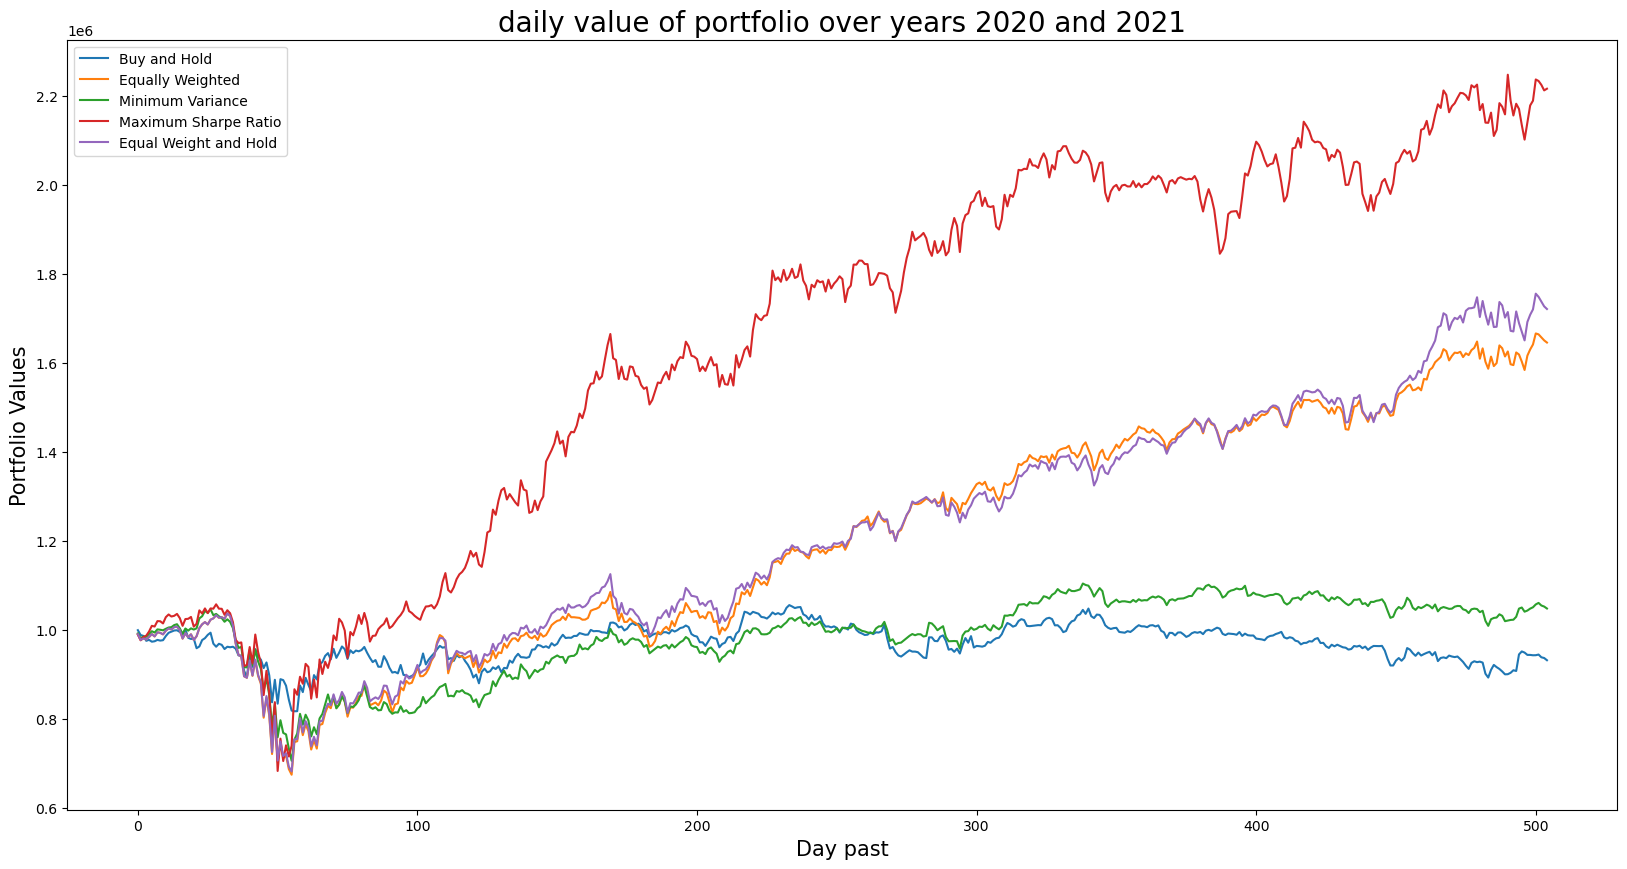

In [15]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0],label='Buy and Hold')
plt.plot(portf_value[1],label='Equally Weighted')
plt.plot(portf_value[2],label='Minimum Variance')
plt.plot(portf_value[3],label='Maximum Sharpe Ratio')
plt.plot(portf_value[4],label='Equal Weight and Hold')
plt.title('daily value of portfolio over years 2020 and 2021',fontsize=20)
plt.xlabel('Day past',fontsize=15)
plt.ylabel('Portfolio Values',fontsize=15)
plt.legend()
plt.show()